## Face Mask Detection using Convolutional Neural Networks

## Learning Objectives

At the end of the experiment, we will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool. 
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1059 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset
  
- Without Mask/ With Mask/ Partial Mask
  
Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [3]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
import glob, os

### Analyzing the shape and distribution of datasets

In [3]:
partial = glob.glob("/content/MP2_FaceMask_Dataset/train/partial_mask/*")
on = glob.glob("/content/MP2_FaceMask_Dataset/train/with_mask/*")
off = glob.glob("/content/MP2_FaceMask_Dataset/train/without_mask/*")
len(partial), len(on), len(off)

(1294, 1624, 2138)

In [4]:
total = partial + on + off
len(total)

5056

In [5]:
height, width  = [],[]
for i in total:
  im = PIL.Image.open(i)
  height.append(np.array(im).shape[0])
  width.append(np.array(im).shape[1])

In [6]:
print(max(height),min(height), sum(height)/len(height))
print(max(width),min(width),sum(width)/len(width))

4608 141 449.3785601265823
3456 110 434.44026898734177


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.



In [7]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10,target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=50, 
                                                         target_size=(224, 224))

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


In [9]:
train_generator.class_indices

{'partial_mask': 0, 'with_mask': 1, 'without_mask': 2}

In [10]:
next(train_generator)[0].shape

(10, 224, 224, 3)

In [9]:
input_shap = next(train_generator)[0].shape[1:]
input_shap

(224, 224, 3)

### Visualize the sample images of each class using data generator

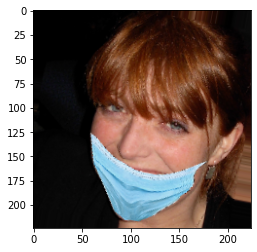

In [12]:
plt.imshow(next(train_generator)[0][0]);

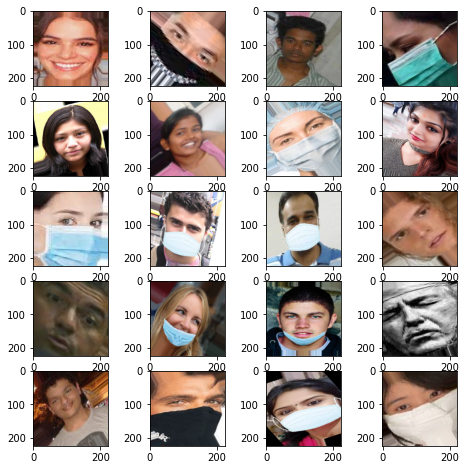

In [13]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(next(train_generator)[0][0])
plt.show()

## Build the CNN model using Keras



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**  

Passing an image with input shape of 3-D and to calculate the output: 

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool** 

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of: 

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is: 

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

**model 1 with 2 convolutional (feature representation) and 2 maxpool layers (down sampling) and 2 dense layers for classification.**

In [14]:
model1 = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(input_shap)),            #convolutional layer 1: No. of filters=100, filter size=3x3, activation = relu, input_shap = 224x224x3,
    MaxPooling2D(2,2),                                                          #Maxpooling2D filter size=2x2
    
    Conv2D(100, (3,3), activation='relu'),                                      #convolutional layer 2: No. of filters=100, filter size=3x3, activation = relu,
    MaxPooling2D(2,2),                                                          #Maxpooling2D filter size=2x2
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(train_generator.num_classes, activation='softplus')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [15]:
model1.summary()
#Note: Applying a convolution to an image will make it smaller (if no padding). 
#Convolving a 3x3 filter over images means we’ll lose a single pixel on all sides (2 in total). 
#In the given case, sliding a 3x3 filter over a 224x224 image results in a 222x222 image

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 100)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 100)     90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 291600)            0         
                                                                 
 dropout (Dropout)           (None, 291600)            0

In [17]:
history1 = model1.fit(train_generator,epochs=1,validation_data=validation_generator)

503/503 [==============================] - 1680s 3s/step - loss: 0.8854 - acc: 0.5383 - val_loss: 0.5538 - val_acc: 0.5743


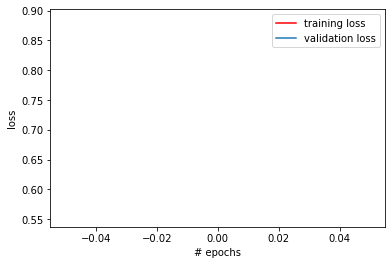

In [18]:
plt.plot(history1.history['loss'],'r',label='training loss')
plt.plot(history1.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**model 2 with few more conv layers**

In [19]:
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(input_shap)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (2,2),activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (2,2),activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(1920, activation='relu'),
    Dense(480, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [20]:
history2 = model2.fit(train_generator,epochs=1,validation_data=validation_generator)

503/503 [==============================] - 695s 1s/step - loss: 0.2142 - acc: 0.8807 - val_loss: 0.1169 - val_acc: 0.9412


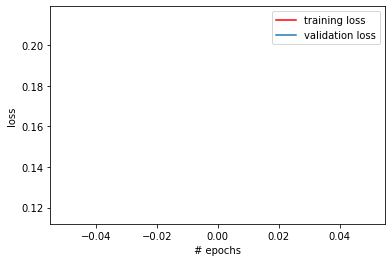

In [21]:
plt.plot(history2.history['loss'],'r',label='training loss')
plt.plot(history2.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Transfer learning

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Pre-trained models ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16) or [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50))

* Load the pre-trained model
* Fit and evaluate the data


#### Expected accuracy: Morethan 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tuning the network by modifying fully connected layers.
* Re-train the model with our problem data

#### VGG16

In [10]:
model_vgg = Sequential()
model_vgg.add(VGG16(weights='imagenet',include_top=False,input_shape=(input_shap)))
model_vgg.add(Flatten())
model_vgg.add(Dense(128,activation="relu",kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01)))
model_vgg.add(Dense(train_generator.num_classes,activation='softmax'))
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 17,926,467
Trainable params: 17,926,467
Non-trainable params: 0
_________________________________________________________________


In [11]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.00001)
model_vgg.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history3 = model_vgg.fit(train_generator,epochs=1,
                              validation_data=validation_generator, class_weight={0:1.0,1:0.8,2:1.2})

101/503 [=====>........................] - ETA: 2:10:02 - loss: 2.8153 - acc: 0.8515

In [ ]:
plt.plot(history3.history['loss'],'r',label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#### ResNet50

In [ ]:
model_resnet = Sequential()
model_resnet.add(ResNet50(weights='imagenet',include_top=False,input_shape=(input_shap)))
model_resnet.add(Flatten())
model_resnet.add(Dense(128))
model_resnet.add(Dense(train_generator.num_classes,activation='softmax'))
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_resnet.build((next(train_generator)[0].shape))
model_resnet.summary()

In [ ]:
history3 = model_resnet.fit(train_generator,epochs=1,
                    validation_data=validation_generator)

In [ ]:
plt.plot(history3.history['loss'],'r',label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Capture the live image using the below code cell and predict

In [ ]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.


* Converting the image to numpy array and resize to the shape which model accept. 
* Extending the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

In [ ]:
MODEL = model_vgg
features = PIL.Image.open("photo.jpg")
features = features.resize((224, 224))
plt.imshow(features);
features = np.array(features).reshape(1, 224,224,3)
predicted = MODEL.predict(features)
print("fc = ",predicted)
print("labels to decode ",train_generator.class_indices)
print("argmax of fc ",np.argmax(predicted))
list(train_generator.class_indices.keys())[np.argmax(predicted)]

### Kaggle predictions

In [ ]:
# Download the saved VGG model
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/model_vgg.h5

In [ ]:
#@title Download test data and SampleSubmission file for Kaggle submission
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
!unzip -qq FaceMask_Kaggle_test.zip
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
print("Data Downloaded Successfuly!!")

#### Create a dataframe with kaggle data

In [ ]:
df = pd.DataFrame()
df['img_path'] = glob.glob("FaceMask_Kaggle_test/*")
df['order'] = [int(i.split("/")[1][:-4]) for i in df['img_path']]
df.sort_values('order',inplace=True)
df.reset_index(inplace=True,drop=True)
df

In [ ]:
df.iloc[120:135]

#### Extract features of kaggle data

In [ ]:
kaggle_features = []
for i in df.img_path:
  im = np.array(PIL.Image.open(i).resize((224,224)))
  if im.shape != (224,224,3):
    print(i, im.shape)
  kaggle_features.append(im)
  
kaggle_features = np.array(kaggle_features)

#### Load the saved model and predict the kaggle features

In [ ]:
# Loading the saved model
model = keras.models.load_model('/content/model_vgg.h5')

In [ ]:
pred = model.predict(kaggle_features)

In [ ]:
act_pred = np.argmax(pred,axis=1)
set(act_pred)

#### Prepare the kaggle predictions CSV file after decoding the integer predictions

In [ ]:
kaggle = pd.DataFrame()
kaggle['label'] = act_pred
kaggle['img_path'] = df['img_path']
kaggle['label'].replace(0,'partial_mask',inplace=True)
kaggle['label'].replace(1,'with_mask',inplace=True)
kaggle['label'].replace(2,'without_mask',inplace=True)

In [ ]:
kaggle.to_csv("kaggle_submission_w2.csv",index=False)